In [ ]:
%matplotlib inline
import spacy
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.cluster import kmeans, cosine_distance

In [ ]:
nlp = spacy.load('es_core_news_sm')
nlp.max_length = 5000000

In [3]:
with open('lavoztextodump.txt') as f:
    # I don't have enough memory to run it with all the data on my machine
    text = f.read()[:5000000]
    doc = nlp(text)


In [4]:
# Extract sentences
sentences = list(filter(lambda x: len(x) >= 10, doc.sents))

In [5]:
# Lemmatized the words
words = []
lemmatized_words = []

for sentence in sentences:
    for word in sentence:
        if word.is_alpha:
            lemmatized_words.append(word.lemma_)
            words.append((word, word.lemma_))

lemmatized_words_counter = Counter(lemmatized_words)

In [6]:
# Remove stops
filtered_words = [
    (w, l) for (w, l) in words if not w.is_stop]


In [7]:
dicc = {}

threshold_a = 60
threshold_b = 30

for (w, l) in filtered_words:

    if lemmatized_words_counter[l] < threshold_a or w.like_num:
        continue

    features = dicc.get(l, {})

    keys = [f"POS__{w.pos_}", f"DEP__{w.dep_}", w.tag_]

    def grab_context(index):
        w_ctx = doc[index]
        w_ctx_lemma = w_ctx.lemma_
        if w_ctx.is_digit:
            keys.append(f'TRIPLA__{l}__{w.dep_}__NUM')
        elif w_ctx.is_alpha and lemmatized_words_counter[w_ctx_lemma] > threshold_b:
            keys.append(f'TRIPLA__{l}__{w.dep_}__{w_ctx_lemma}')

    if w.i != 0:
        grab_context(w.i - 1)
    if w.i + 1 < len(doc):
        grab_context(w.i + 1)

    for key in keys:
        features[key] = features.get(key, 0) + 1
    dicc[l] = features

In [8]:
features = []
key_words = {}
wid = 0
for d in dicc:
    key_words[d] = wid
    wid += 1
    features.append(dicc[d])


In [9]:
v = DictVectorizer(sparse=False)
matrix = v.fit_transform(features)

In [10]:
matrix_normed = matrix / matrix.max(axis=0)
variances = np.square(matrix_normed).mean(axis=0) - np.square(matrix_normed.mean(axis=0))
threshold_v = 0.001
red_matrix = np.delete(matrix_normed, np.where(variances < threshold_v), axis=1)

In [11]:
tsne = TSNE(n_components=2, random_state=0)
matrix_dicc2d = tsne.fit_transform(red_matrix)

In [12]:
pointsspacy = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, matrix_dicc2d[key_words[word]])
            for word in key_words
        ]
    ],
    columns=["word", "x", "y"]
)

<AxesSubplot:xlabel='x', ylabel='y'>

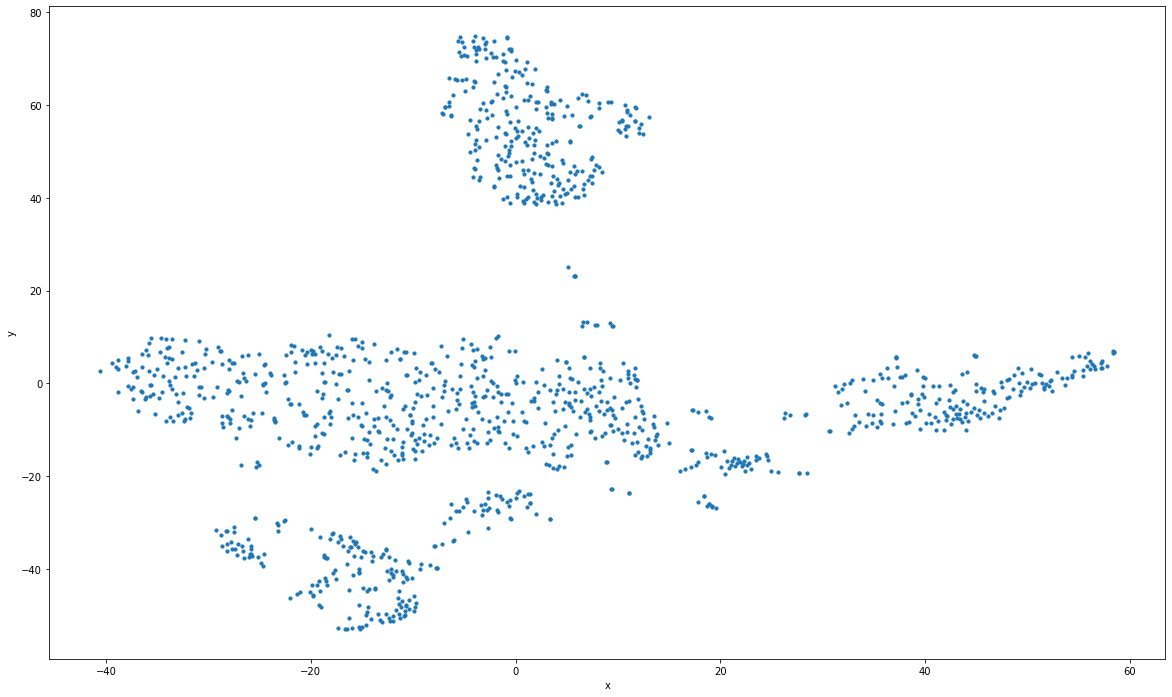

In [13]:
pointsspacy.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [14]:
def clustering(k):
    clusterer = kmeans.KMeansClusterer(k, cosine_distance, avoid_empty_clusters=True)
    clusters = clusterer.cluster(red_matrix, True)
    return clusters

In [15]:
c50 =  clustering(50)
c100 = clustering(100)

In [16]:
clusters = c100

In [17]:
pointscluster = pd.DataFrame(
    [
        (word, coords[0], coords[1], cluster)
        for word, coords, cluster in [
            (word, matrix_dicc2d[key_words[word]], clusters[key_words[word]])
            for word in key_words
        ]
    ],
    columns=["word", "x", "y", "c"]
)

/home/carusox/.local/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


<AxesSubplot:xlabel='x', ylabel='y'>

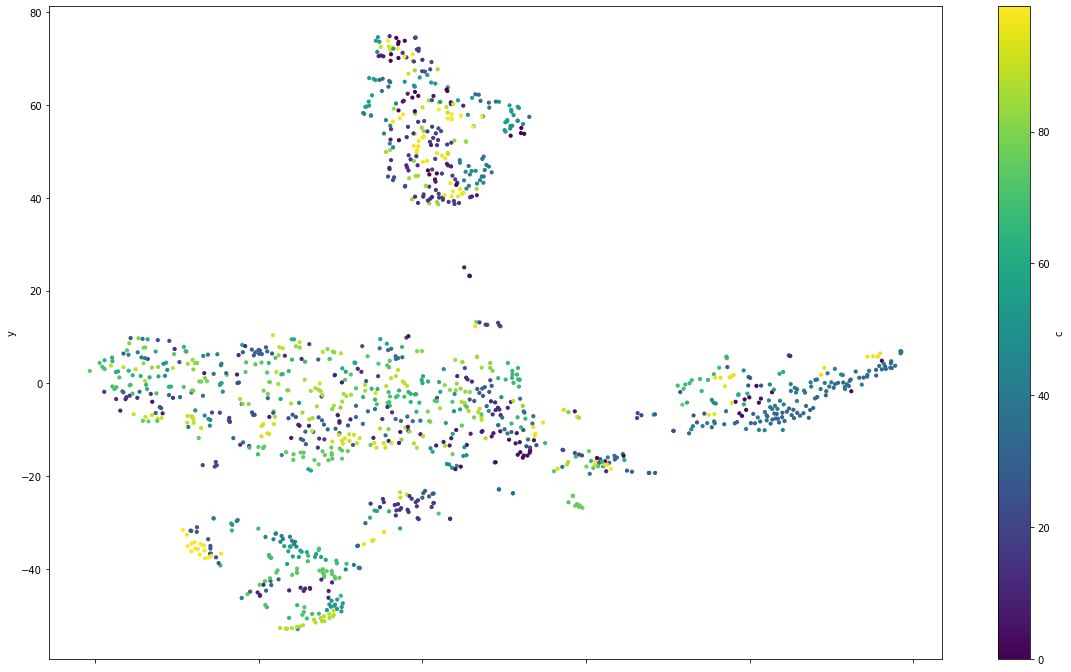

In [18]:
pointscluster.plot.scatter(x='x', y='y', c='c', cmap='viridis', s=10, figsize=(20, 12))

In [19]:
clusterPresidente = [word for word in key_words if clusters[key_words[word]] == clusters[key_words["presidente"]]]
print(clusterPresidente)

['joven', 'chica', 'jefe', 'presidente', 'funcionario', 'dirigente', 'ministro', 'titular', 'encuesta', 'especialista', 'líder', 'dueño', 'secretario', 'abogado', 'delegado', 'investigador', 'conductor', 'fiscal', 'vecino', 'inspector', 'monto']


In [23]:
clusterNoche = [word for word in key_words if clusters[key_words[word]] == clusters[key_words["noche"]]]
print(clusterNoche)

['noche', 'viernes', 'lunes', 'marzo', 'junio', 'noviembre']


In [25]:
clusterViaje = [word for word in key_words if clusters[key_words[word]] == clusters[key_words["viaje"]]]
print(clusterViaje)

['pareja', 'educación', 'acción', 'calidad', 'canal', 'acceso', 'grado', 'consulta', 'rechazo', 'valor', 'compromiso', 'viaje', 'bien', 'servicio', 'control', 'pobreza', 'obligación', 'libertad', 'par', 'confianza', 'conocimiento', 'cultura', 'homicidio', 'justicia', 'tarjeta', 'ayuda', 'gasto', 'voluntad', 'embargo']
